# Backpropagation Lab





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import normalize
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

## 1. Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with 0 mean. Remember that every hidden and output node should have its own bias weight.
- Use stochastic training updates: update weights after each training instance (i.e. not batch)
- Implement a validation set based stopping criterion. Keep your *BSSF* and once you go *w* epochs with no improvement (e.g. 10) then use the weights from the *BSSF*.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [ ]:
class bssf:
  def __init__(self, weights, num_epochs, train_mse, val_mse, test_mse):
    self.weights= weights
    self.num_epochs = num_epochs
    self.train_mse = train_mse
    self.val_mse = val_mse
    self.test_mse = test_mse
  
  def UpdateWeights(self, weights):
    self.weights = weights
  def UpdateEpochs(self, epochs):
    self.num_epochs = epochs
  def UpdateTrain(self,train_mse):
    self.train_mse = train_mse
  def UpdateVal(self,val_mse):
    self.val_mse = val_mse
  def UpdateTest(self,test_mse):
    self.test_mse = test_mse

  def GetWeights(self):
    return self.weights
  def GetEpochs(self):
    return self.num_epochs
  def GetAccuracy(self):
    return self.train_mse, self.val_mse, self.test_mse

class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None,num_epochs=None,split=None, validation=None, mse=False, zeros=False):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths=hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.split=split
        self.validation=validation
        self.mse=mse
        self.zeros = zeros

    def _split(self, X, y):
      X, X_test, y, y_test = train_test_split(X, y, test_size=self.split, shuffle=True)
      self.X_test = X_test
      self.y_test = y_test
      return X,y


    def fit(self, X, y, initial_weights=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        row, col = X.shape
        num_inputs = col
        row_y, col_y = y.shape
        num_outputs = col_y

        self.weights = self.initialize_weights(input=num_inputs, output=num_outputs) if not initial_weights else initial_weights

        self.bssf = bssf(self.weights, 0, math.inf, math.inf, math.inf)
        if self.shuffle:
            X, y = self._shuffle_data(X,y)
        
        if self.split:
          X, y = self._split(X, y)


        # TRAINING LOOP WITH VALIDATION SET
        if self.validation:
          X, X_val, y, y_val = train_test_split(X, y, test_size=self.validation, shuffle=True)
          self.X_val = X_val
          self.y_val = y_val

          row_xval, col_xval = X_val.shape
          row_yval, col_yval = y_val.shape


          epochs_no_change = 0
          prev_acc = 0
          self.val_set = []
          self.train_set = []
          self.test_set = []
          # SET PREV CHANGE TO ZERO 
          prev_change = copy.deepcopy(self.weights)
          for l in prev_change:
            for r in prev_change:
              r.fill(0) 
          num_epochs = 0

          # RUN UNTIL VAL SET NO CHANGE OR MAX EPOCHS
          while epochs_no_change < 10 and num_epochs < self.num_epochs:
            num_epochs += 1

            # CHECK TEST< TRAIN< AND VAL ACC 
            score = self.score(X,y)
            self.train_set.append(score)
            for cntr in range(1):
              test_acc = self.score(self.X_test, self.y_test)
              self.test_set.append(test_acc)
            for cntr in range(1):
              val_acc = self.score(X_val, y_val)
              self.val_set.append(val_acc)
              if val_acc - prev_acc == 0:
                epochs_no_change += 1
              else:
                # UPDATE BSSF
                if val_acc - self.bssf.GetAccuracy()[1] < 0:
                  weights = self.weights
                  self.bssf.UpdateWeights(weights)
                  self.bssf.UpdateEpochs(num_epochs)
                  self.bssf.UpdateTrain(score)
                  self.bssf.UpdateVal(val_acc)
                  self.bssf.UpdateTest(test_acc)
                epochs_no_change = 0
              prev_acc = val_acc
            # FOR EACH SERIES IN THE DATA SET CREAT A LIST OF NET VALS
            for cntr in range(len(X)):
              first = X[cntr]
              first = np.append(first, [1])
              net_vals = [first]
              # print(net_vals)
              for layer in range(len(self.hidden_layer_widths)):
                layer_net_list = []
                for node in range(self.hidden_layer_widths[layer]):
                  # print(f"layer: {layer} node: {node}")
                  # print(f"net vals for layer: {net_vals[layer]}, weights: {self.weights[layer][:,node]}")
                  net = np.sum([net_vals[layer] * self.weights[layer][:,node]])
                  net_exp = 1/(1 + np.exp(-net))
                  # print(f"net: {net_exp}")
                  
                  layer_net_list.insert(0,net_exp)
                if (len(self.hidden_layer_widths) - layer > 1):
                  layer_net_list.append(1)
                net_vals.append(layer_net_list)
              # print(net_vals)
              s_outs = []
              for layer in reversed(range(len(self.hidden_layer_widths))):
                for node in (range(self.hidden_layer_widths[layer])):
                  # print(f"Layer: {layer}, Node: {node}")
                  if layer == len(self.hidden_layer_widths) - 1:
                    s = (y[cntr][self.hidden_layer_widths[layer] - node -1] - net_vals[-1][node]) * (net_vals[-1][node] * (1 - net_vals[-1][node]))
                    # print(f"s equation: {s} = ({y[node]} - {net_vals[-1][node]}) * ({net_vals[-1][node]} * {1 - net_vals[-1][node]})")
                    s_outs.append(s)
                  else:
                    if self.hidden_layer_widths[layer] == node -1:
                      continue
                    else:
                      list = []
                      index = len(self.weights[layer + 1][node]) - 1
                      for x in self.weights[layer + 1][node]:
                        list.append(x * s_outs[index])
                        # print(f"addition = {x} * {s_outs[index]}")
                        index = index - 1
                    # print(net_vals)
                    # print(list)
                    s = np.sum(list) * (net_vals[layer + 1][node] * (1 - net_vals[layer + 1][node]))
                    # print(f"weights: {self.weights[layer + 1]}")
                    # print(f" s equation: sum {list} * {net_vals[layer + 1][node]} ")
                    # print(f"S = {np.sum(list)} * ({net_vals[layer + 1][node]} * {1 - net_vals[layer + 1][node]}) = {s}")
                    s_outs.append(s)
                # print(f"S scores: {s_outs}")
              num_s = 0
              for layer in range(len(self.weights)):
                if layer > 0:
                  num_s += layer * len(self.weights[layer -1][0])
                for row in range(len(self.weights[layer])):
                  for col in range(len(self.weights[layer][row])):     
                    # print(self.weights)
                    # print(f"svals: {s_outs}")
                    # print(f"S_val at {(len(s_outs) - 1) - (col  + num_s)} is {s_outs[(len(s_outs) - 1) - (col  + num_s)]}")
                    momentum = self.momentum * prev_change[layer][row][col]
                    # print(f"Momentum: {momentum} = {self.momentum} * {prev_change[layer][row][col]}")
                    change = (self.lr * s_outs[(len(s_outs) - 1) - (col  + (num_s))] * net_vals[layer][row]) + momentum
                    self.weights[layer][row][col] += change
                    # if row == 0 and col == 0:
                    #   print(f"svals: {s_outs}")
                    #   print(f"Layer: {layer}, Row: {row}, Column: {col} Num_s: {num_s}")
                    #   print(f"weight: {self.weights[layer][row][col]}")
                    #   print(f"Prev Change: {prev_change[layer][row][col]} * Momentum: {self.momentum} + change: {change}")
                    #   print(f"Change: {self.lr} * {s_outs[(len(s_outs) - 1) - (col + (num_s))]} * {net_vals[layer][row]} + {momentum} = {change} ")
                    #   print(prev_change)
                    #   print(self.weights)
                    prev_change[layer][row][col] = change
            if self.shuffle:
              X, y = self._shuffle_data(X,y)

        else:
          prev_change = copy.deepcopy(self.weights)
          for l in prev_change:
            for r in prev_change:
              r.fill(0) 
          for epoch in range(self.num_epochs):
            for cntr in range(len(X)):
              first = X[cntr]
              first = np.append(first, [1])
              net_vals = [first]
              # print(net_vals)
              for layer in range(len(self.hidden_layer_widths)):
                layer_net_list = []
                for node in range(self.hidden_layer_widths[layer]):
                  # print(f"layer: {layer} node: {node}")
                  # print(f"net vals for layer: {net_vals[layer]}, weights: {self.weights[layer][:,node]}")
                  net = np.sum([net_vals[layer] * self.weights[layer][:,node]])
                  net_exp = 1/(1 + np.exp(-net))
                  # print(f"net: {net_exp}")
            
                  layer_net_list.insert(0,net_exp)
                if (len(self.hidden_layer_widths) - layer > 1):
                  layer_net_list.append(1)
                net_vals.append(layer_net_list)
              # print(net_vals)
              s_outs = []
              for layer in reversed(range(len(self.hidden_layer_widths))):
                for node in (range(self.hidden_layer_widths[layer])):
                  # print(f"Layer: {layer}, Node: {node}")
                  if layer == len(self.hidden_layer_widths) - 1:
                    # print(net_vals[-1])
                    s = (y[cntr][self.hidden_layer_widths[layer] - node -1] - net_vals[-1][node]) * (net_vals[-1][node] * (1 - net_vals[-1][node]))
                    # print(f"s eq/uation: {s} = ({y[cntr][1]} - {net_vals[-1][node]}) * ({net_vals[-1][node]} * {1 - net_vals[-1][node]})")
                    # print(f"s eq/uation: {s} = ({y[cntr][0]} - {net_vals[-1][node]}) * ({net_vals[-1][node]} * {1 - net_vals[-1][node]})")
                    s_outs.append(s)
                  else:
                    if self.hidden_layer_widths[layer] == node -1:
                      continue
                    else:
                      list = []
                      index = len(self.weights[layer + 1][node]) - 1
                      for x in self.weights[layer + 1][node]:
                        list.append(x * s_outs[index])
                        # print(f"addition = {x} * {s_outs[index]}")
                        index = index - 1
                    # print(net_vals)
                    # print(list)
                    s = np.sum(list) * (net_vals[layer + 1][node] * (1 - net_vals[layer + 1][node]))
                    # print(f"weights: {self.weights[layer + 1]}")
                    # print(f" s equation: sum {list} * {net_vals[layer + 1][self.hidden_layer_widths[layer] - node -1]} ")
                    # print(f"S = {np.sum(list)} * ({net_vals[layer + 1][node]} * {1 - net_vals[layer + 1][node]}) = {s}")
                    s_outs.insert(self.hidden_layer_widths[layer - 1], s)
                # print(f"S scores: {s_outs}")
              num_s = 0
              for layer in range(len(self.weights)):
                if layer > 0:
                  num_s += layer * len(self.weights[layer -1][0])
                for row in range(len(self.weights[layer])):
                  for col in range(len(self.weights[layer][row])):     
                    # print(self.weights)
                    # print(f"svals: {s_outs}")
                    # print(f"S_val at {(len(s_outs) - 1) - (col  + num_s)} is {s_outs[(len(s_outs) - 1) - (col  + num_s)]}")
                    momentum = self.momentum * prev_change[layer][row][col]
                    # print(f"Momentum: {momentum} = {self.momentum} * {prev_change[layer][row][col]}")
                    change = (self.lr * s_outs[(len(s_outs) - 1) - (col  + (num_s))] * net_vals[layer][row]) + momentum
                    self.weights[layer][row][col] += change
                    # if layer == 0 and row == 0 and col == 1:
                    #   print(f"svals: {s_outs}")
                    #   print(f"Layer: {layer}, Row: {row}, Column: {col} Num_s: {num_s}")
                    #   print(f"weight: {self.weights[layer][row][col]}")
                    #   print(f"Prev Change: {prev_change[layer][row][col]} * Momentum: {self.momentum} + change: {change}")
                    #   print(f"Change: {self.lr} * {s_outs[(len(s_outs) - 1) - (col + (num_s))]} * {net_vals[layer][row]} + {momentum} = {change} ")
                    #   print(prev_change)
                    #   print(self.weights)
                    prev_change[layer][row][col] = change
            if self.shuffle:
              X,y = self._shuffle_data(X,y)
                  
        return self

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predicted_targets = []
        weights = self.bssf.weights
        for index in range(len(X)):
          prediction = []
          # print(X[index])
          net = np.append(X[index],1)
          for layer in range(len(weights)):
            net = np.dot(net, weights[layer])
            net = np.append(net, 1)
          if (len(net) - 1) == 1:
            if net[0] > 0:
              prediction.append(1)
            else:
              prediction.append(0)
            predicted_targets.append(prediction)
          else:
            count = 0
            for n in range(len(net) - 1):
              # print(f"n at {n} = {net[n]} max: {np.max(net[0:len(net) - 1])}")
              net_softmax = softmax(net)
              if net_softmax[n] == np.max(net_softmax[0:len(net) - 1]) and count == 0:
                prediction.append(1)
                count += 1
              else:
                prediction.append(0)
            # print(f"prediction: {prediction}")
            predicted_targets.append(prediction)
        return predicted_targets

    def initialize_weights(self, input, output):
        """ Initialize weights for perceptron. Don't forget the bias!


        Returns:

        """
        outputs = self.hidden_layer_widths
        outputs.append(output)

        layers = len(outputs)
        mu, std = 0, .1
        cols = input

        all_weights = []
        for layer in range(layers):
          rows = cols + 1
          cols = outputs[layer]
          if self.zeros:
            weights = np.zeros(shape=(rows,cols))
          else:
            weights = np.random.normal(mu, std, size=(rows, cols))
          all_weights.append(weights)
        return all_weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """

        predicted_targets = self.predict(X)
        if self.mse:
          # SSE = 0
          # for index in range(len(predicted_targets)):
          #   for y_in in range(len(y[0])):
          #     if y[index][y_in] == 1:
          #       SSE += np.square(y[index][y_in] - predicted_targets[index][y_in])
          # MSE = np.divide(SSE,len(predicted_targets))
          MSE = mean_squared_error(y, predicted_targets)
          # print(MSE)
          return MSE
        else:
          # total = 0
          # # print(f'Predicted Targets length: {len(predicted_targets)}  Num series: {len(y)}')
          # for index in range(len(y)):
          #   # if index % 100 == 1:
          #     # print(f" y: {y[index]}, predictions: {predicted_targets[index]}")
          #   if np.array_equal(y[index], predicted_targets[index]):
          #     total += 1
          # return total/len(predicted_targets)
          acc = accuracy_score(y, predicted_targets)
          return acc

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        row, col = y.shape
        cat = np.concatenate((X, y), axis=1)
        np.random.shuffle(cat)
        cat = np.hsplit(cat, [len(cat[0]) -col])
        X = cat[0]
        y = cat[1]
        return X,y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights


## 1.1 Debug and Evaluation

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 (20%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$


Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

Based on how you index your weights, they may not be in the exact order or shape as our two examples above, but the weight values should be the same.

In [ ]:
# Load debug data

# Train on debug datafrom scipy.io import arff
from scipy.io import arff
import pandas as pd

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep2nonorigin.arff

test_data_unclean = arff.loadarff('linsep2nonorigin.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
test_data_from_scipy = pd.get_dummies(test_data_from_scipy)
linsep_np_data = test_data_from_scipy.to_numpy()
linsep_np_data = linsep_np_data.astype(float)

test_data_split= np.hsplit(linsep_np_data, [2])
X = test_data_split[0]
y_init = test_data_split[1]
# Train on debug data

mlp = MLP(lr=.1, momentum=.5, num_epochs=10, shuffle=False, hidden_layer_widths=[4], zeros=True)
mlp.fit(X,y_init)

mlp2 = MLP(lr=.1, momentum=.5, num_epochs=10, shuffle=False, hidden_layer_widths=[4], zeros=True)
mlp2.fit(X,np.hsplit(y_init, [1])[1])


# Have your code print your accuracy and weights

print(mlp2.get_weights())
print(mlp.get_weights())



# Print weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   1683      0 --:--:-- --:--:-- --:--:--  1669
[array([[-8.81779797e-05, -8.81779797e-05, -8.81779797e-05,
        -8.81779797e-05],
       [ 7.82757731e-04,  7.82757731e-04,  7.82757731e-04,
         7.82757731e-04],
       [-3.94353645e-03, -3.94353645e-03, -3.94353645e-03,
        -3.94353645e-03]]), array([[-0.01060888],
       [-0.01060888],
       [-0.01060888],
       [-0.01060888],
       [-0.02145495]])]
[array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
       [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
       [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]), array([[ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.01050642, -0.01050642],
       [ 0.02148778, -0.02148778]])]


*Discussion*
At first I trainied my model to do the binary classification, and was able to get the correct weights. But after looking at the Iris classification problem, I updated it to do one hot encoding. The first array matches the first layer of weights and the second corresponds to the second.

### 1.1.2 (20%) Evaluation

Evaluate your model using the same parameters as above for the Debug data set

We will evaluate your model based on the weights your code prints after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [ ]:
# Load evaluation data

# Train on evaluation data

# Print weights# Load evaluation data
from scipy.io import arff
import pandas as pd

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output data_banknote_authentication.arff

test_data_unclean = arff.loadarff('data_banknote_authentication.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
test_data_from_scipy = pd.get_dummies(test_data_from_scipy)
banknote_np_data = test_data_from_scipy.to_numpy()
banknote_np_data = banknote_np_data.astype(float)

test_data_split= np.hsplit(banknote_np_data, [4])
X = test_data_split[0]
y_init = test_data_split[1]

# Train on evaluation data

mlp = MLP(lr=.1, momentum=.5, num_epochs=10, shuffle=False, hidden_layer_widths=[4], zeros=True)
mlp.fit(X,y_init)

mlp2 = MLP(lr=.1, momentum=.5, num_epochs=10, shuffle=False, hidden_layer_widths=[4], zeros=True)
mlp2.fit(X,np.hsplit(y_init, [1])[1])

# Print weights

print(mlp2.get_weights())
print(mlp2.score(X, np.hsplit(y_init, [1])[1]))

print(mlp.get_weights())
print(mlp.score(X, y_init))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   168k      0 --:--:-- --:--:-- --:--:--  168k
[array([[ 1.30932366,  1.30932366,  1.30932366,  1.30932366],
       [ 0.80601033,  0.80601033,  0.80601033,  0.80601033],
       [ 0.92744187,  0.92744187,  0.92744187,  0.92744187],
       [ 0.22165294,  0.22165294,  0.22165294,  0.22165294],
       [-1.45313731, -1.45313731, -1.45313731, -1.45313731]]), array([[-1.88512443],
       [-1.88512443],
       [-1.88512443],
       [-1.88512443],
       [ 4.57969955]])]
0.9803206997084548
[array([[ 1.63828721,  1.63828721,  1.63828721,  1.63828721],
       [ 1.09612249,  1.09612249,  1.09612249,  1.09612249],
       [ 1.23447594,  1.23447594,  1.23447594,  1.23447594],
       [ 0.39269487,  0.39269487,  0.39269487,  0.39269487],
       [-2.09316151, -2.09316151, -2.09316151, -2.09316151]]), array([[ 1.81695

*Discussion*
Using the binary model initially, I decided to switch to one hot and both times I trained my model the accuracy was .9803, which is excellent. This problem was easily learned by my mlp

## 2. (10%) Backpropagation on the Iris Classification problem.

Train on the [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff). For this and all following experiments, always start with random weights and shuffle the training set before each epoch. You may use your own data shuffling code and random train/test split code or use scikit-learn versions if you prefer.

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a random 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (10-15% of the training set is common) taken from the training set for your stopping criteria. 
- Create one graph with MSE (mean squared error, *y*-axis) vs epochs (*x*-axis) for the MSEs on the training set, validation set, and test set. Always include the values at epoch 0 (your initial weights before training)
- Create one graph with classification accuracy (% classified correctly) vs epochs from the training set, validation set, and test set

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

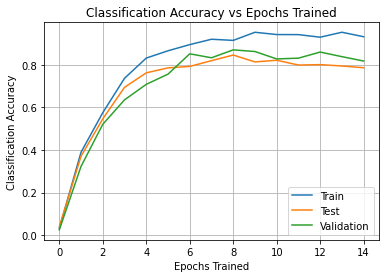

In [ ]:
# Sample Graph
import matplotlib.pyplot as plt
import numpy as np

# Use the accuracies/MSEs from your own mlp
train_data = 2.5*np.log(np.linspace(1,3.5,15))/(np.linspace(1,3.5,15))+1/20*np.random.random(15)
test_data = 2.2*np.log(np.linspace(1,3.9,15))/(np.linspace(1,3.9,15))+1/25*np.random.random(15)
val_data = 2.9*np.log(np.linspace(1,3,15))/(np.linspace(1,4,15))+1/15*np.random.random(15)

plt.plot(train_data, label="Train")
plt.plot(test_data, label='Test')
plt.plot(val_data, label='Validation')
plt.legend(loc="lower right")
plt.xlabel('Epochs Trained')
plt.ylabel('Classification Accuracy')
plt.title("Classification Accuracy vs Epochs Trained")
plt.grid()
plt.show()

In [ ]:
#@title Default title text
# Iris Classification
from scipy.io import arff
import pandas as pd

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

test_data_unclean = arff.loadarff('iris.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
test_data_from_scipy = pd.get_dummies(test_data_from_scipy)
iris_np_data = test_data_from_scipy.to_numpy()

test_data_split= np.hsplit(iris_np_data, [4])
X = test_data_split[0]
X = X.astype(float)
y_init = test_data_split[1]

mlp = MLP(lr=.1, shuffle=True, hidden_layer_widths=[8], split=.2, validation=.1, mse=True, num_epochs=20)
mlp.fit(X,y_init)
print(mlp.score(X,y_init))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  35140      0 --:--:-- --:--:-- --:--:-- 35306


TypeError: ignored

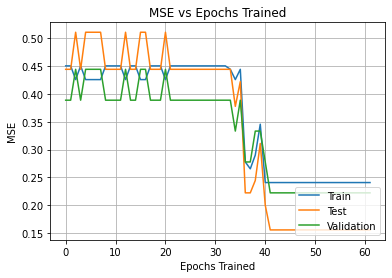

In [ ]:
train_data = mlp.train_set
test_data = mlp.test_set
val_data = mlp.val_set

plt.plot(train_data, label="Train")
plt.plot(test_data, label='Test')
plt.plot(val_data, label='Validation')
plt.legend(loc="lower right")
plt.xlabel('Epochs Trained')
plt.ylabel('MSE')
plt.title("MSE vs Epochs Trained")
plt.grid()
plt.show()

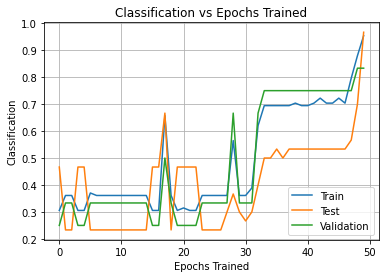

In [ ]:
train_data = mlp.train_set
test_data = mlp.test_set
val_data = mlp.val_set

plt.plot(train_data, label="Train")
plt.plot(test_data, label='Test')
plt.plot(val_data, label='Validation')
plt.legend(loc="lower right")
plt.xlabel('Epochs Trained')
plt.ylabel('Classification')
plt.title("Classification vs Epochs Trained")
plt.grid()
plt.show()

*Discussion*
My model didn't quite reach the 85-95% range with the80/20/10 split, but my validation set did reach 90% itself. After 5 epochs with no change in the validation set, I cut off the learning. My train and test set had similar accuracy all along the way. The MSE was almost the same graph just inverted. The test set always ran against the bssf from the training set, and that is the best assumption of how my model will generalize, which was about 75%. I was frustrated with the results, so I upped the number of epochs to 20 and then I pushed it a little farther and I finally got the test set to get about 85% accuracy which is what I have displayed here. The MSE also looks a lot better. Goes to show that the 5 epochs with no change is pretty small. 

## 3. Working with Hyperparameters 
### 3.1 (5%) Vowel Dataset - Intuition
- In this section we use the vowel dataset to consider the hyperparameters of learning rate, number of hidden nodes, and momentum.
- Discuss why the vowel data set has lower accuracy than Iris.
- Report both dataset's baseline accuracies. Baseline accuracy is what you would get if the model just outputs the majority class of the data set.
- Consider which of the vowel datasets given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.

*Discuss these items here*
The baseline for the iris is 33% because there are only three outputs equally represented- so if you guess one classification every time, you would get it right 33% of the time. Vowel dataset has 11 possible classifications represented equally, so the baseline is about 9%. 
The vowel dataset is a harder problem- it has more features and targets. Its more difficult to classify, so it makes sense the accuracy is lower.
From the vowel dataset I chose to include all the features except name, gender, and Train/test. The Train/test was immaterial to my mlp- it just takes all the data and splits it itself. The sex and speaker were a little more difficult, but I tried running it with and without both and it performed about the same either way. I ended up reporting the data with the sex and speaker included with a one-hot encoding approach, because I think there could be a correlation between a speaker and the sound, as well as gender. So knowing those features could help it guess the correct sound, even if in practice I didn't see much change. I know that its best to have fewer features, and since the performance was the same I decided to use the 10 labeled features and dropped the sex and speaker number as well. 

### 3.2 (10%) Learning Rate
Load the [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 75/25 splits of the data for the training/test set.
- Use a validation set taken from the training set for your stopping criteria.
- Try some different learning rates (LR). Note that each LR will require a different number of epochs to learn. 
- These hyperparamaters can effect both accuracy and time required for learning. For each LR you test, plot their validations set's MSE (*y*-axis) vs epochs (*x*-axis). Graph 4-5 different LRs and make them different enough to see a difference between them. For stopping use a window of 5 epochs since no change from *BSSF*. 5 is smaller than typical but fine for demonstrating and viewing the concept here. Show the values for the 5 epochs past *BSSF* but put a point at the *BSSF* epoch to make it clear which model you actually choose for each learning rate. Below is an example graph with made up data. We include the Matplotlib code which you may use as a template, but you may use any graphing tools you want.
- Create a table which includes a row for the final chosen model for each LR, showing the LR, # epochs to learn the model, and the final MSE for the training set, validation set, and test set.


In real testing one averages the results of multiple trials per LR with different intitial conditions. That gives more accurate results but is not required for your report.


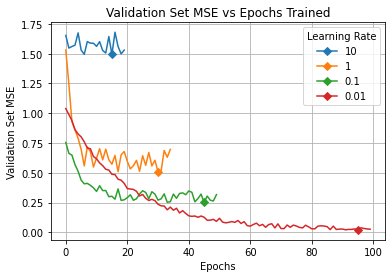

In [ ]:
# Sample Graph Code
import matplotlib.pyplot as plt
import numpy as np

# Fake Data 
def mlp(i, lr):
  x1 = np.exp(-.001*np.linspace(0,20,20))+1/5*np.random.random(20)+.5
  x2 = np.exp(-.5*np.linspace(0,35,35))+1/5*np.random.random(35)+.5
  x3 = .5*np.exp(-.2*np.linspace(0,50,50))+1/10*np.random.random(50)+.25
  x4 = np.exp(-.05*np.linspace(0,100,100))+1/25*np.random.random(100)
  data = [x1, x2, x3, x4]
  for x in data: x[-5] = np.amin(x)-.001
  return data[i]

# Graph code
lrs=[10, 1, .1, .01] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early 
for i, lr in enumerate(lrs):
  mse = mlp(i, lr) # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=lr)
plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [ ]:
# Train with different learning rates
# Train on each dataset
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel.arff

test_data_unclean = arff.loadarff('vowel.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
test_data_from_scipy = test_data_from_scipy.drop(labels=["Train or Test", "Speaker Number", "Sex"], axis=1)
test_data_from_scipy = pd.get_dummies(test_data_from_scipy)
vowel_np_data = test_data_from_scipy.to_numpy()


test_data_split= np.hsplit(vowel_np_data, [11])
X = test_data_split[0]
X = X.astype(float)
X = normalize(X, axis=1)
y_init = test_data_split[1]

mlp = MLP(lr=.1, shuffle=True, hidden_layer_widths=[20], mse=False, num_epochs=100)
mlp.fit(X,y_init)




MLP(hidden_layer_widths=[20, 10], num_epochs=100)

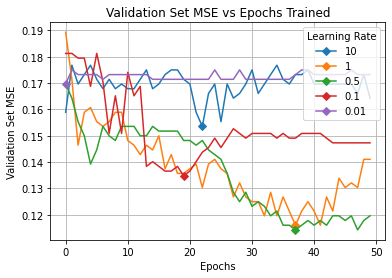

In [ ]:
# Graph code
lrs=[10, 1, .5, .1, .01] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early 
for i, lr in enumerate(lrs):
  mlp = MLP(lr=lr, shuffle=True, hidden_layer_widths=[20], mse=True, split=.25, validation=.15, num_epochs = 50)
  mlp.fit(X,y_init)
  mse = mlp.val_set # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=lr)
plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [ ]:
from tabulate import tabulate
headers = ["LR", "epochs", "MSE Train", "MSE Test", "MSE Val"]
table = [[10,1,.1653,.1672,.1642],
         [1,2,.1521,.1379,.1568],
         [.5,5,.1437,.1412,.1466],
         [.1,11,.1388,.1331,.1341],
         [.01,68,.1356,.1444,.1414]]
print(tabulate(table, headers=headers))

   LR    epochs    MSE Train    MSE Test    MSE Val
-----  --------  -----------  ----------  ---------
10            1       0.1653      0.1672     0.1642
 1            2       0.1521      0.1379     0.1568
 0.5          5       0.1437      0.1412     0.1466
 0.1         11       0.1388      0.1331     0.1341
 0.01        68       0.1356      0.1444     0.1414


*Discuss the effect of different learning rates from your graph and table*
Varying learning rates impact the size of the step you make in a given direction. small learning rates will get you where you need to go- just very slowly. A large learning rate is much worse, as it could cause you to step to far and miss the minima. I found that when my learning rate was too big my error was much larger. But with really small learning rates the classifier took forever to converge- I had to stop it early anything below about .1, which was my sweet spot. It had very similar MSE but actually could converge

### 3.3 (10%) Number of Hidden Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create both a graph and table just like above, except with # of hidden nodes rather than LR.

In general, whenever you are testing a parameter such # of hidden nodes, test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

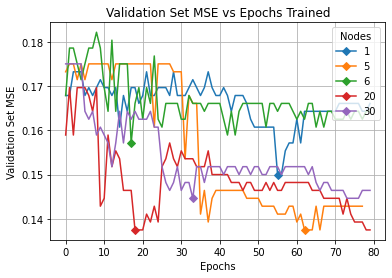

In [ ]:
# Train with different numbers of hidden nodes
nodes=[1, 5, 6, 20, 30] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early 
for i, node in enumerate(nodes):
  mlp = MLP(lr=.1, shuffle=True, hidden_layer_widths=[nodes[i]], mse=True, split=.25, validation=.15, num_epochs = 80)
  mlp.fit(X,y_init)
  mse = mlp.val_set # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=nodes[i])
plt.legend(title="Nodes", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [ ]:
from tabulate import tabulate
headers = ["Nodes", "epochs", "MSE Train", "MSE Test", "MSE Val", "Test Accuracy"]
table = [[1,80,.1599,.1655,.1641, .568],
         [5,80,.1379,.1452,.1429, .601],
         [6,80,.1502,.1568,.1637, .575],
         [20,80,.1314,.1302,.1392, .621],
         [30,80,.1346,.1534,.1479, .609]]
print(tabulate(table, headers=headers))

  Nodes    epochs    MSE Train    MSE Test    MSE Val    Test Accuracy
-------  --------  -----------  ----------  ---------  ---------------
      1        80       0.1599      0.1655     0.1641            0.568
      5        80       0.1379      0.1452     0.1429            0.601
      6        80       0.1502      0.1568     0.1637            0.575
     20        80       0.1314      0.1302     0.1392            0.621
     30        80       0.1346      0.1534     0.1479            0.609


*Discuss the effect of different numbers of hidden nodes from your graph and table* 
Seems like the more hidden layers I used, the lower the MSE was, but that wasn't perfectly true. Too many hidden nodes isn't a problem- some of the nodes just won't be useful. Too few nodes could lead the problem to not generalize as well, so I would err on the side of more but don't be exorbidant. Sometime trial and error is the best solution. I found about 20 to be my happy place


### 3.4 (10%) Momentum

Try some different momentum terms between 0 and 1 using the best number of hidden nodes and LR from your earlier experiments.

- Create both a graph and table just like above, except with different momentum values rather than LR.

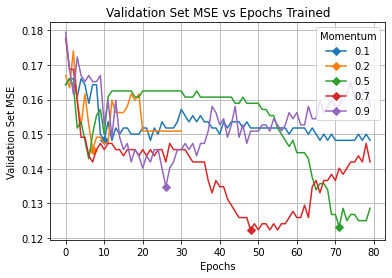

In [ ]:
# Train with different momentum values
nodes=[.1, .2, .5, .7, .9] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early 
for i, node in enumerate(nodes):
  mlp = MLP(lr=.1, shuffle=True, hidden_layer_widths=[30], mse=True, split=.25, validation=.15, momentum=node, num_epochs=80)
  mlp.fit(X,y_init)
  mse = mlp.val_set # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=nodes[i])
plt.legend(title="Momentum", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [ ]:
from tabulate import tabulate
headers = ["Momentum", "epochs", "MSE Train", "MSE Test", "MSE Val", "Test Accuracy"]
table = [[.1,80,.1456,.1500,.1494, .615],
         [.2,30,.1521,.1476,.1501, .603],
         [.5,80,.1173,.1240,.1290, .697],
         [.7,80,.1397,.1451,.1419, .617],
         [.9,80,.1513,.1610,.1586, .598]]
print(tabulate(table, headers=headers))

  Momentum    epochs    MSE Train    MSE Test    MSE Val    Test Accuracy
----------  --------  -----------  ----------  ---------  ---------------
       0.1        80       0.1456      0.15       0.1494            0.615
       0.2        30       0.1521      0.1476     0.1501            0.603
       0.5        80       0.1173      0.124      0.129             0.697
       0.7        80       0.1397      0.1451     0.1419            0.617
       0.9        80       0.1513      0.161      0.1586            0.598


*Discuss the effect of different momentum values from your graph and table*
As I increased the momentum, the mlp was able to converge faster. This is because momentum increases the learning rate when the mlp is moving the weights in the same direction for awhile. The longer it is there, the larger the momentum and consequently the learning rate. 0.5 as my momentum constant was the best option for me after this table run

## 4. Scikit-learn Classifier and Comparison

### 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris data set and one data set of your choice.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try some different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [ ]:
# Load sklearn MLP
# Load sklearn perceptron
X_train, X_test, y, y_test = train_test_split(X, y_init, test_size=.2)

# Train on Iris and one other data set

mlp2 = MLPClassifier(hidden_layer_sizes=(30), learning_rate_init=.1,activation="tanh", momentum=0.9, nesterovs_momentum=True, early_stopping=True)
mlp2.fit(X_train,y)



MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=30,
              learning_rate_init=0.1)

*Discussion* As a general rule, the MLPClassifier from scikit learn performed better than my mlp. After about 20 hidden layers on the MLPClassifier I didn't see much change in the score. seems like right around there was a good number of hidden nodes, which was similar to my mlp. The the learning rate around .1 was best for both. It took much longer to converge if it was any smaller, and too big poorly impacted the scores often. I tried a few different activation functions for the scikit learn classifier. The sigmoid was the best. I expected ReLu to perform better than it did. The tanh was also pretty good, but less consistent. The nestorov momentum helped keep the scores more consitently better. When I had a large momentum sometimes it would do very poorly, but with nestorv it includes some weight decay that really helped stablize the scores. 

### 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid or random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [ ]:
# Load sklearn MLP
# Load sklearn perceptron
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
# Train on voting dataset
mlp2 = MLPClassifier(hidden_layer_sizes=(30), learning_rate_init=.1, activation='logistic', momentum=0.9, nesterovs_momentum=True)

parameters = {'learning_rate_init': sp_randFloat(),
                  'momentum' : sp_randFloat(0,0.1),
                  'hidden_layer_sizes'    : 
                 }
clf = RandomizedSearchCV(mlp2, parameters)
clf.fit(X_train, y)
print(f" Best Params: {clf.best_params_}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

 Best Params: {'hidden_layer_sizes': 10, 'learning_rate_init': 0.1273388548796197, 'momentum': 0.09635898102864099}


In [ ]:
mlp2 = MLPClassifier(hidden_layer_sizes=(10), learning_rate_init=0.1273388548796197, activation='logistic',momentum=0.09635898102864099, nesterovs_momentum=True)
mlp2.fit(X_train, y)
mlp2.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9666666666666667

*Discussion*
Best Params: {'hidden_layer_sizes': 39, 'learning_rate_init': 0.1713685657428089, 'momentum': 0.034040177558505594}
Accuracy: 0.9666666666666667

### 5. (Optional 5% Extra credit) For the Iris data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, momentum, and any other hyperparamters you want to consider.  

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

mlp2 = MLPClassifier(hidden_layer_sizes=(30), learning_rate_init=.1, activation='logistic', momentum=0.9, nesterovs_momentum=True)

parameters = {'learning_rate_init': [.1,.2,.7,.8,.9],
                  'momentum' : [.001,.005,.01,.1,.9],
                  'hidden_layer_sizes'    : [2,8,10,20,30]
                 }
clf = GridSearchCV(mlp2, parameters)
clf.fit(X_train, y)
print(f" Best Params: {clf.best_params_}")
print(f"Accuracy: {clf.score(X_test, y_test)}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

 Best Params: {'hidden_layer_sizes': 8, 'learning_rate_init': 0.2, 'momentum': 0.1}
Accuracy: 0.9666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


*Discuss your results and any differences*
 Best Params: {'hidden_layer_sizes': 8, 'learning_rate_init': 0.2, 'momentum': 0.1}
 The best params for the random search produced consitently better scores, although the grid search best score was similar to the random best score. grid search only has a limited number of options to work through, so this makes sense. Random search can try out several more combinations of parameters. The downside is it did take much longer to finish than the grid search. I suppose since the Iris dataset is kind of small its not nearly as hard to get the good parameters and that is why sometimes the grid search could do as well.